In [1]:
!pip install tensorflow keras pandas matplotlib seaborn scikit-learn opencv-python


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Concatenate
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os, shutil, random


In [3]:
DATASET = "/content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset"
HYBRID_DATA = "/content/fish_hybrid_no_yolo_lowacc"

train_dir = f"{HYBRID_DATA}/train"
val_dir   = f"{HYBRID_DATA}/val"
test_dir  = f"{HYBRID_DATA}/test"

if os.path.exists(HYBRID_DATA):
    shutil.rmtree(HYBRID_DATA)
os.makedirs(train_dir)
os.makedirs(val_dir)
os.makedirs(test_dir)

# Filter out 'images' and 'labels' if they are directly listed by os.listdir at the top level
# and ensure only directories corresponding to classes are processed.
all_items = os.listdir(DATASET)
classes = [item for item in all_items if os.path.isdir(os.path.join(DATASET, item)) and item not in ['images', 'labels']]

print(f"Detected classes: {classes}")

for cls in classes:
    os.makedirs(f"{train_dir}/{cls}", exist_ok=True)
    os.makedirs(f"{val_dir}/{cls}", exist_ok=True)
    os.makedirs(f"{test_dir}/{cls}", exist_ok=True)

    # Assume images are in a subdirectory named 'images' within each class folder
    class_specific_image_dir = os.path.join(DATASET, cls, 'images')

    # Fallback: if 'images' subdirectory doesn't exist, assume images are directly in the class folder
    if not os.path.exists(class_specific_image_dir):
        class_specific_image_dir = os.path.join(DATASET, cls)

    print(f"Processing images from: {class_specific_image_dir} for class: {cls}")

    # List only files (not directories) from the determined image directory
    imgs = [f for f in os.listdir(class_specific_image_dir) if os.path.isfile(os.path.join(class_specific_image_dir, f))]

    if not imgs:
        print(f"Warning: No image files found in {class_specific_image_dir} for class {cls}. Skipping this class.")
        continue

    random.shuffle(imgs)
    n = len(imgs)

    train_split = int(0.7*n)
    val_split   = int(0.9*n)

    print(f"  Total images: {n}, Train: {train_split}, Val: {val_split-train_split}, Test: {n-val_split}")

    for img_name in imgs[:train_split]:
        shutil.copy(os.path.join(class_specific_image_dir, img_name), f"{train_dir}/{cls}")
    for img_name in imgs[train_split:val_split]:
        shutil.copy(os.path.join(class_specific_image_dir, img_name), f"{val_dir}/{cls}")
    for img_name in imgs[val_split:]:
        shutil.copy(os.path.join(class_specific_image_dir, img_name), f"{test_dir}/{cls}")

print("✅ Dataset split completed!")


Detected classes: ['Bacterial red Disease', 'Viral diseases White tail disease', 'Parasitic diseases', 'Bacterial gill Disease', 'Fungal Disease', 'Bacterial diseases', 'Healthy fish']
Processing images from: /content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset/Bacterial red Disease/images for class: Bacterial red Disease
  Total images: 1250, Train: 875, Val: 250, Test: 125
Processing images from: /content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset/Viral diseases White tail disease/images for class: Viral diseases White tail disease
  Total images: 1000, Train: 700, Val: 200, Test: 100
Processing images from: /content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset/Parasitic diseases/images for class: Parasitic diseases
  Total images: 1000, Train: 700, Val: 200, Test: 100
Processing images from: /content/drive/MyDrive/Roboflow Annotation Fish Disease Dataset/Bacterial gill Disease/images for class: Bacterial gill Disease
  Total images: 1229, Train: 860,

In [4]:
# Two feature extractors
img_size = 224 # Define image size
input_layer = Input(shape=(img_size,img_size,3))

# Backbone 1
backbone1 = MobileNetV2(weights="imagenet", include_top=False, input_tensor=input_layer)
backbone1.trainable = False
x1 = Flatten()(backbone1.output)

# Backbone 2
backbone2 = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=input_layer)
backbone2.trainable = False
x2 = Flatten()(backbone2.output)

# Concatenate features
concat = Concatenate()([x1, x2])
concat = Dense(128, activation='relu')(concat)
concat = Dropout(0.4)(concat)
output = Dense(len(classes), activation='softmax')(concat)

hybrid_model = Model(inputs=input_layer, outputs=output)
hybrid_model.compile(optimizer=Adam(1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
hybrid_model.summary()


/tmp/ipython-input-3090799249.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone1 = MobileNetV2(weights="imagenet", include_top=False, input_tensor=input_layer)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 22,364,906 (85.32 MB)

 Trainable params: 16,057,351 (61.25 MB)

 Non-trainable params: 6,307,555 (24.06 MB)

In [5]:
num_classes = len(classes)
img_size = 224 # Ensure img_size is defined for ImageDataGenerator
batch_size = 32

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

# Flow data from directories
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

history = hybrid_model.fit(train_data, validation_data=val_data, epochs=12, verbose=1)



Found 5396 images belonging to 7 classes.
Found 1542 images belonging to 7 classes.
Found 772 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
169/169 ━━━━━━━━━━━━━━━━━━━━ 104s 394ms/step - accuracy: 0.1819 - loss: 2.6388 - val_accuracy: 0.3126 - val_loss: 1.6490
Epoch 2/12
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.3020 - loss: 1.6975 - val_accuracy: 0.4663 - val_loss: 1.4916
Epoch 3/12
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.4017 - loss: 1.4850 - val_accuracy: 0.5415 - val_loss: 1.3031
Epoch 4/12
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.4377 - loss: 1.3382 - val_accuracy: 0.6427 - val_loss: 1.1248
Epoch 5/12
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.5073 - loss: 1.1869 - val_accuracy: 0.6751 - val_loss: 1.0065
Epoch 6/12
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.5409 - loss: 1.0575 - val_accuracy: 0.7095 - val_loss: 0.9294
Epoch 7/12
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.5715 - loss: 0.9718 - val_accuracy: 0.7270 - val_loss: 0.8533
Epoch 8/12
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.5993 - loss: 0.89

In [6]:
df = pd.DataFrame(history.history)
df.to_csv("/content/drive/MyDrive/hybrid_no_yolo_lowacc.csv", index=False)
print("📄 CSV saved to Drive")


📄 CSV saved to Drive


In [7]:
df = pd.DataFrame(history.history)
df.to_csv("/content/drive/MyDrive/hybrid_no_yolo_lowacc.csv", index=False)
print("📄 CSV saved to Drive")


📄 CSV saved to Drive


25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 876ms/step


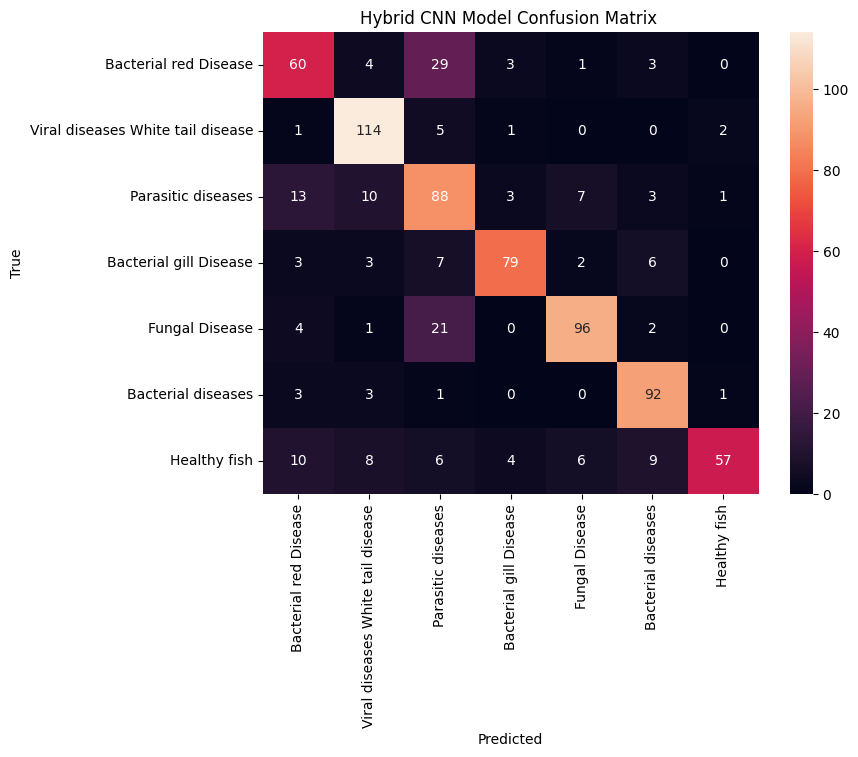

                                   precision    recall  f1-score   support

            Bacterial red Disease       0.64      0.60      0.62       100
Viral diseases White tail disease       0.80      0.93      0.86       123
               Parasitic diseases       0.56      0.70      0.62       125
           Bacterial gill Disease       0.88      0.79      0.83       100
                   Fungal Disease       0.86      0.77      0.81       124
               Bacterial diseases       0.80      0.92      0.86       100
                     Healthy fish       0.93      0.57      0.71       100

                         accuracy                           0.76       772
                        macro avg       0.78      0.76      0.76       772
                     weighted avg       0.78      0.76      0.76       772



In [8]:
y_true = test_data.classes
y_pred = hybrid_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title("Hybrid CNN Model Confusion Matrix ")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))


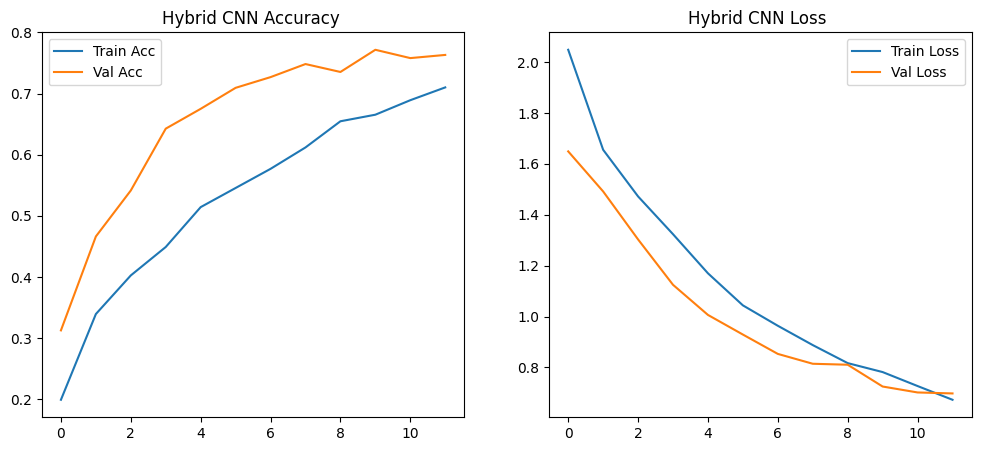

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Hybrid CNN Accuracy ")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Hybrid CNN Loss ")
plt.legend()
plt.show()
